In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchhd
from torchhd.memory import SparseDistributed
import numpy as np
import matplotlib.pyplot as plt
import umap
import pickle
import os

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.manual_seed(42)

# Create pkl directory for caching
os.makedirs("../pkl", exist_ok=True)

print(f"Device: {device}")

/opt/anaconda3/envs/sscp/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/sscp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: mps


## 1. Load and preprocess MNIST data

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

hd_dim = 2000
BASIS_VECTORS = torchhd.random(784, hd_dim, device=device)


def encode_mnist_hd(image):
    flat_img = image.view(-1).to(device)
    binary = (flat_img > 0.1).float()
    encoded = torch.matmul(binary, BASIS_VECTORS)
    return encoded.sign()


print(f"Training: {len(train_dataset)}, Test: {len(test_dataset)}")
print(f"HD dimension: {hd_dim}")

Training: 60000, Test: 10000
HD dimension: 2000


## 2. Initialize SDM structure

In [3]:
memory_size = 100000
p = 0.005

# Try to load existing SDM
if os.path.exists("../pkl/sdm_model.pkl"):
    print("Loading existing SDM model...")
    with open("../pkl/sdm_model.pkl", "rb") as f:
        sdm = pickle.load(f)
else:
    print("Creating new SDM model...")
    sdm = SparseDistributed(memory_size, hd_dim, 10, p=p, device=device)

print(f"Memory size: {memory_size}")
print(f"HD dimension: {hd_dim}")
print(f"Sparsity: {p}")

Loading existing SDM model...
Memory size: 100000
HD dimension: 2000
Sparsity: 0.005


## 3. Train the SDM model

In [4]:
num_batches = 400

# Skip training if model already exists
if not os.path.exists('../pkl/sdm_model.pkl'):
    print("Training Standard SDM model (clean images only)...")
    for batch_idx, (data, targets) in enumerate(train_loader):
        if batch_idx >= num_batches:
            break

        data = data.to(device)
        targets = targets.to(device)

        # No noise - clean images only
        encoded_batch = torch.stack([encode_mnist_hd(img) for img in data])
        one_hot = torch.zeros(targets.size(0), 10, device=device)
        one_hot.scatter_(1, targets.unsqueeze(1), 1)

        sdm.write(encoded_batch, one_hot)

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}/{num_batches}")

    print(f"Training samples: {num_batches*64} (clean images only)")

    # Save trained model
    print("Saving Standard SDM model...")
    with open('../pkl/sdm_model.pkl', 'wb') as f:
        pickle.dump(sdm, f)
else:
    print("Using pre-trained Standard SDM model")

Using pre-trained Standard SDM model


## 4. Evaluate on test set

In [5]:
correct = 0
total = 0

for batch_idx, (data, targets) in enumerate(test_loader):
    if batch_idx >= 50:
        break

    data = data.to(device)
    targets = targets.to(device)

    encoded_batch = torch.stack([encode_mnist_hd(img) for img in data])
    outputs = sdm.read(encoded_batch)
    predictions = torch.argmax(outputs, dim=1)

    correct += (predictions == targets).sum().item()
    total += targets.size(0)

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.1f}% ({correct}/{total})")

Accuracy: 70.9% (2268/3200)


## 5. Train Robust SDM Model

In [6]:
# Skip training if robust model already exists
if os.path.exists('../pkl/sdm_robust_model.pkl'):
    print("Loading existing robust SDM model...")
    with open('../pkl/sdm_robust_model.pkl', 'rb') as f:
        robust_sdm = pickle.load(f)
else:
    print("Training Robust SDM model (with noise augmentation)...")
    robust_sdm = SparseDistributed(memory_size, hd_dim, 10, p=p, device=device)

    # Noise levels for training
    noise_levels = [0.0, 0.1, 0.25, 0.4]

    for batch_idx, (data, targets) in enumerate(train_loader):
        if batch_idx >= num_batches:
            break

        data = data.to(device)
        targets = targets.to(device)

        # Apply random noise to each sample (no color inversion)
        noisy_data = data.clone()
        for i in range(data.size(0)):
            noise_level = np.random.choice(noise_levels)
            if noise_level > 0:
                flip_mask = torch.rand_like(data[i]) < noise_level
                noisy_data[i][flip_mask] = 1 - noisy_data[i][flip_mask]

        encoded_batch = torch.stack([encode_mnist_hd(img) for img in noisy_data])
        one_hot = torch.zeros(targets.size(0), 10, device=device)
        one_hot.scatter_(1, targets.unsqueeze(1), 1)

        robust_sdm.write(encoded_batch, one_hot)

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}/{num_batches}")

    print(f"Training samples: {num_batches*64} (with noise augmentation: {noise_levels})")

    # Save trained robust model
    print("Saving Robust SDM model...")
    with open('../pkl/sdm_robust_model.pkl', 'wb') as f:
        pickle.dump(robust_sdm, f)

print("Robust SDM model ready!")

Loading existing robust SDM model...
Robust SDM model ready!


## 6. Noise Robustness Analysis

### 1. Digit 4 with Increasing Noise

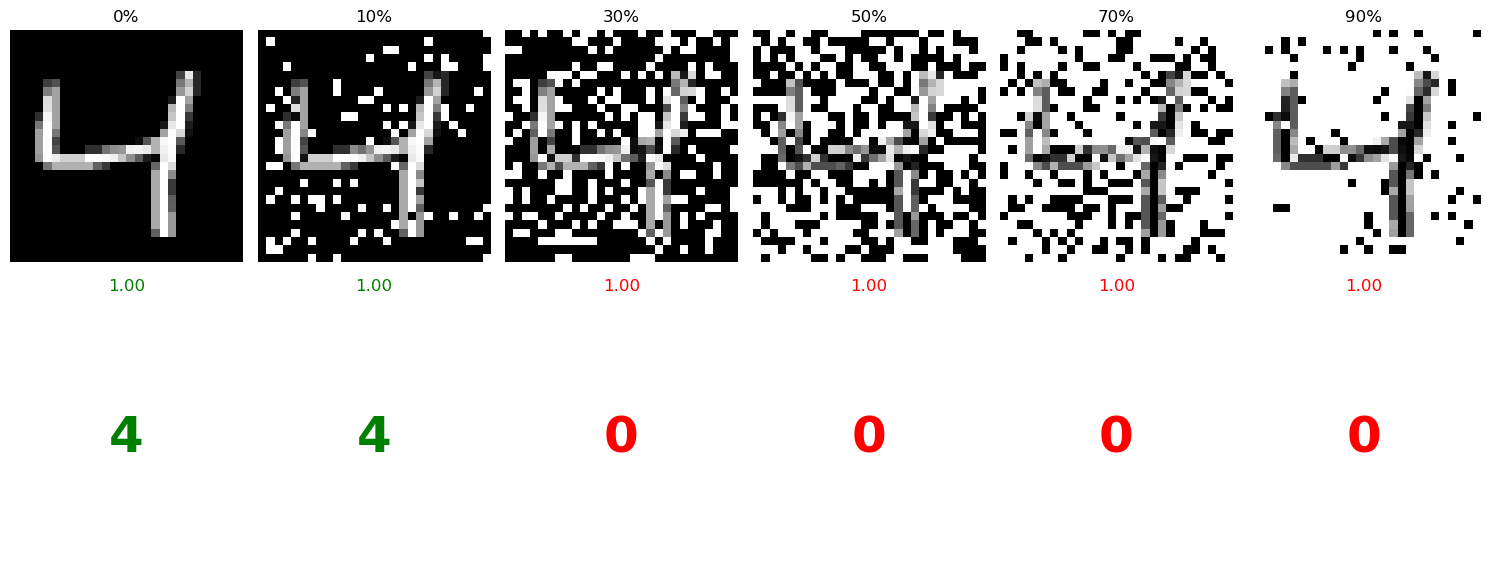

In [7]:
digit_4 = None
for img, label in train_dataset:
    if label == 4:
        digit_4 = img.squeeze()
        break

noise_levels = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
fig, axes = plt.subplots(2, len(noise_levels), figsize=(15, 6))

for i, noise in enumerate(noise_levels):
    noisy_digit = digit_4.clone()
    if noise > 0:
        flip_mask = torch.rand_like(noisy_digit) < noise
        noisy_digit[flip_mask] = 1 - noisy_digit[flip_mask]

    encoded_noisy = encode_mnist_hd(noisy_digit).unsqueeze(0)
    output = sdm.read(encoded_noisy)
    predicted = torch.argmax(output, dim=1).item()
    confidence = torch.max(torch.softmax(output, dim=1)).item()

    axes[0, i].imshow(noisy_digit.cpu(), cmap="gray", vmin=0, vmax=1)
    axes[0, i].set_title(f"{int(noise*100)}%")
    axes[0, i].axis("off")

    color = "green" if predicted == 4 else "red"
    axes[1, i].text(
        0.5,
        0.5,
        f"{predicted}",
        fontsize=36,
        ha="center",
        va="center",
        color=color,
        weight="bold",
        transform=axes[1, i].transAxes,
    )
    axes[1, i].set_title(f"{confidence:.2f}", color=color)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

### 2. Recall Accuracy vs. Noise Level

Loading existing recall accuracy data...


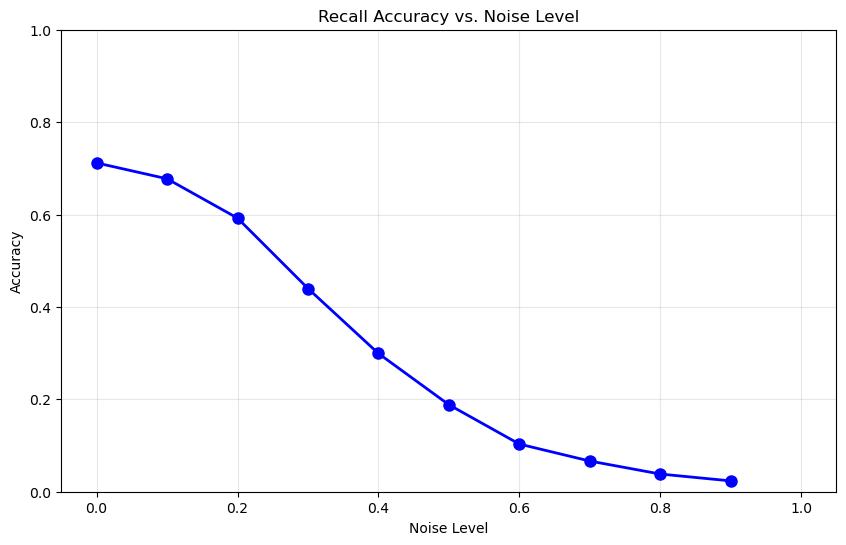

In [8]:
# Try to load existing recall accuracy data
if os.path.exists("../pkl/recall_accuracy_data.pkl"):
    print("Loading existing recall accuracy data...")
    with open("../pkl/recall_accuracy_data.pkl", "rb") as f:
        data = pickle.load(f)
        # Handle both tuple and dict formats
        if isinstance(data, dict):
            noise_levels = data["noise_levels"]
            accuracies = data["accuracies"]
        else:
            # Assume it's a tuple (noise_levels, accuracies)
            noise_levels, accuracies = data
else:
    print("Computing recall accuracy vs noise...")
    noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    accuracies = []

    for noise in noise_levels:
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(test_loader):
            if batch_idx >= 20:
                break

            data = data.to(device)
            targets = targets.to(device)

            noisy_data = data.clone()
            if noise > 0:
                flip_mask = torch.rand_like(noisy_data) < noise
                noisy_data[flip_mask] = 1 - noisy_data[flip_mask]

            encoded_batch = torch.stack([encode_mnist_hd(img) for img in noisy_data])
            outputs = sdm.read(encoded_batch)
            predictions = torch.argmax(outputs, dim=1)

            correct += (predictions == targets).sum().item()
            total += targets.size(0)

        accuracy = correct / total
        accuracies.append(accuracy)

    # Save recall accuracy data
    print("Saving recall accuracy data...")
    with open("../pkl/recall_accuracy_data.pkl", "wb") as f:
        pickle.dump({"noise_levels": noise_levels, "accuracies": accuracies}, f)

plt.figure(figsize=(10, 6))
plt.plot(noise_levels, accuracies, "b-o", linewidth=2, markersize=8)
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.title("Recall Accuracy vs. Noise Level")
plt.ylim(0.0, 1.0)
plt.xlim(-0.05, 1.05)  # Add padding to show edge points
plt.grid(True, alpha=0.3)
plt.show()

### 3. Hamming Distance vs. Noise Level

Loading existing Hamming distance data...


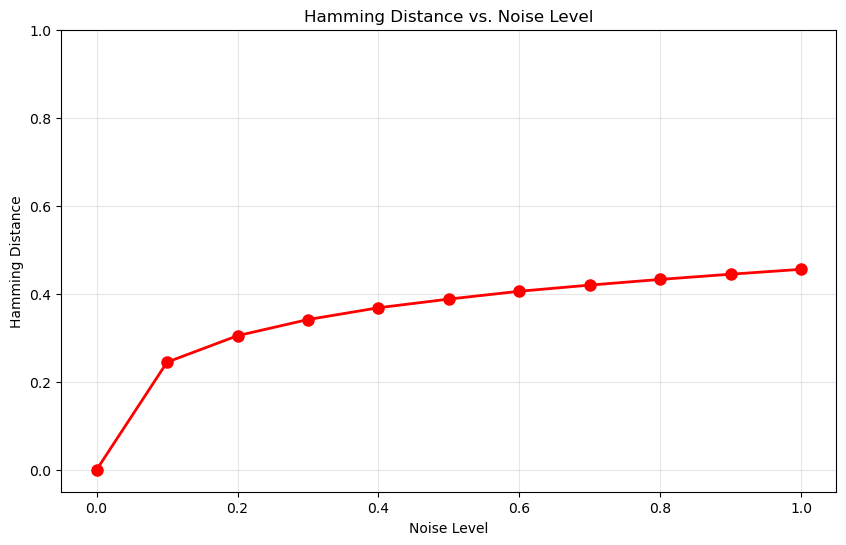

In [9]:
# Try to load existing Hamming distance data
if os.path.exists("../pkl/hamming_distance_data.pkl"):
    print("Loading existing Hamming distance data...")
    with open("../pkl/hamming_distance_data.pkl", "rb") as f:
        data = pickle.load(f)
        # Handle both tuple and dict formats
        if isinstance(data, dict):
            noise_levels = data["noise_levels"]
            hamming_distances = data["hamming_distances"]
        else:
            # Assume it's a tuple (noise_levels, hamming_distances)
            noise_levels, hamming_distances = data
else:
    print("Computing Hamming distance vs noise...")
    noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    hamming_distances = []

    for noise in noise_levels:
        distances = []

        for batch_idx, (data, targets) in enumerate(test_loader):
            if batch_idx >= 20:
                break

            data = data.to(device)

            noisy_data = data.clone()
            if noise > 0:
                flip_mask = torch.rand_like(noisy_data) < noise
                noisy_data[flip_mask] = 1 - noisy_data[flip_mask]

            original_encoded = torch.stack([encode_mnist_hd(img) for img in data])
            noisy_encoded = torch.stack([encode_mnist_hd(img) for img in noisy_data])

            hamming_dist = (original_encoded != noisy_encoded).float().mean(dim=1)
            distances.extend(hamming_dist.cpu().numpy())

        avg_distance = np.mean(distances)
        hamming_distances.append(avg_distance)

    # Save Hamming distance data
    print("Saving Hamming distance data...")
    with open("../pkl/hamming_distance_data.pkl", "wb") as f:
        pickle.dump({"noise_levels": noise_levels, "hamming_distances": hamming_distances}, f)

plt.figure(figsize=(10, 6))
plt.plot(noise_levels, hamming_distances, "r-o", linewidth=2, markersize=8)
plt.xlabel("Noise Level")
plt.ylabel("Hamming Distance")
plt.title("Hamming Distance vs. Noise Level")
plt.ylim(-0.05, 1.0)
plt.xlim(-0.05, 1.05)  # Add padding to show edge points
plt.grid(True, alpha=0.3)
plt.show()

### 4. Capacity Analysis

Loading existing capacity analysis data...


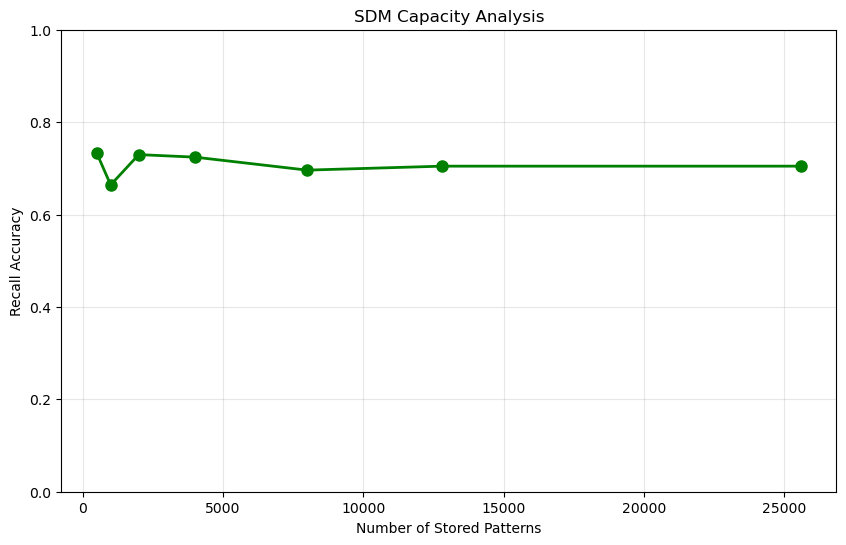

In [10]:
# Try to load existing capacity analysis data
if os.path.exists("../pkl/capacity_analysis_data.pkl"):
    print("Loading existing capacity analysis data...")
    with open("../pkl/capacity_analysis_data.pkl", "rb") as f:
        data = pickle.load(f)
        # Handle both tuple and dict formats
        if isinstance(data, dict):
            pattern_counts = data["pattern_counts"]
            recall_accuracies = data["recall_accuracies"]
        else:
            # Assume it's a tuple (pattern_counts, recall_accuracies)
            pattern_counts, recall_accuracies = data
else:
    print("Computing capacity analysis...")
    pattern_counts = [500, 1000, 2000, 4000, 8000, 12800, 25600]
    recall_accuracies = []

    for num_patterns in pattern_counts:
        # Create fresh SDM
        test_sdm = SparseDistributed(memory_size, hd_dim, 10, p=p, device=device)

        # Train with limited patterns
        patterns_stored = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            if patterns_stored >= num_patterns:
                break

            data = data.to(device)
            targets = targets.to(device)

            # Only take needed samples from batch
            batch_size = min(64, num_patterns - patterns_stored)
            data = data[:batch_size]
            targets = targets[:batch_size]

            encoded_batch = torch.stack([encode_mnist_hd(img) for img in data])
            one_hot = torch.zeros(targets.size(0), 10, device=device)
            one_hot.scatter_(1, targets.unsqueeze(1), 1)

            test_sdm.write(encoded_batch, one_hot)
            patterns_stored += batch_size

        # Test recall on subset
        correct = 0
        total = 0
        for batch_idx, (data, targets) in enumerate(test_loader):
            if batch_idx >= 20:
                break

            data = data.to(device)
            targets = targets.to(device)

            encoded_batch = torch.stack([encode_mnist_hd(img) for img in data])
            outputs = test_sdm.read(encoded_batch)
            predictions = torch.argmax(outputs, dim=1)

            correct += (predictions == targets).sum().item()
            total += targets.size(0)

        accuracy = correct / total
        recall_accuracies.append(accuracy)
        print(f"Patterns: {num_patterns}, Accuracy: {accuracy:.3f}")

    # Save capacity analysis data
    print("Saving capacity analysis data...")
    with open("../pkl/capacity_analysis_data.pkl", "wb") as f:
        pickle.dump({"pattern_counts": pattern_counts, "recall_accuracies": recall_accuracies}, f)

plt.figure(figsize=(10, 6))
plt.plot(pattern_counts, recall_accuracies, "g-o", linewidth=2, markersize=8)
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Recall Accuracy")
plt.title("SDM Capacity Analysis")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
  import umap
  import numpy as np
  test_data = np.random.rand(20, 10)  # Tiny test
  reducer = umap.UMAP(n_neighbors=3)
  embedding = reducer.fit_transform(test_data)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### 5. Vector Analysis & Clustering

In [ ]:
# Try t-SNE instead of UMAP - often faster and more reliable
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

print("Creating HD vector visualization with t-SNE...")

# Collect 20 examples per digit (200 total)
vectors = []
labels = []
images = []

for digit in range(10):
    count = 0
    for img, label in test_dataset:
        if label == digit and count < 20:
            hd_vector = encode_mnist_hd(img)
            vectors.append(hd_vector.cpu().numpy())
            labels.append(label)
            images.append(img.numpy())
            count += 1
        if count >= 20:
            break

print(f"Using {len(vectors)} HD vectors")

# PCA first (essential for t-SNE with high-dim data)
print("Applying PCA preprocessing...")
hd_vectors = np.array(vectors)
pca = PCA(n_components=50)
vectors_reduced = pca.fit_transform(hd_vectors)

# t-SNE (usually faster than UMAP)
print("Computing t-SNE embedding...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=300)
embedding = tsne.fit_transform(vectors_reduced)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                     c=labels, cmap='tab10', s=50, alpha=0.8)
plt.colorbar(scatter, ticks=range(10), label="Digit")
plt.title("MNIST Digits in HD Space (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, alpha=0.3)
plt.show()

# Show some examples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Digit {labels[i]}")
    axes[i].axis('off')

plt.show()
print("t-SNE visualization complete!")

### 6. Digit-Specific Noise Testing

In [ ]:
# Find digit 4 for detailed noise testing
digit_4 = None
for img, label in train_dataset:
    if label == 4:
        digit_4 = img.squeeze()
        break

noise_levels = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
fig, axes = plt.subplots(3, len(noise_levels), figsize=(15, 9))

for i, noise in enumerate(noise_levels):
    # Create noisy version
    noisy_digit = digit_4.clone()
    if noise > 0:
        flip_mask = torch.rand_like(noisy_digit) < noise
        noisy_digit[flip_mask] = 1 - noisy_digit[flip_mask]

    # Test both models
    with torch.no_grad():
        encoded_noisy = encode_mnist_hd(noisy_digit).unsqueeze(0)

        # Original model
        output_orig = sdm.read(encoded_noisy)
        pred_orig = torch.argmax(output_orig, dim=1).item()
        conf_orig = torch.max(torch.softmax(output_orig, dim=1)).item()

        # Robust model
        output_robust = robust_sdm.read(encoded_noisy)
        pred_robust = torch.argmax(output_robust, dim=1).item()
        conf_robust = torch.max(torch.softmax(output_robust, dim=1)).item()

    # Display image
    axes[0, i].imshow(noisy_digit.cpu(), cmap="gray", vmin=0, vmax=1)
    axes[0, i].set_title(f"{int(noise*100)}% Noise")
    axes[0, i].axis("off")

    # Original model prediction
    color_orig = "green" if pred_orig == 4 else "red"
    axes[1, i].text(
        0.5,
        0.5,
        f"{pred_orig}",
        fontsize=36,
        ha="center",
        va="center",
        color=color_orig,
        weight="bold",
        transform=axes[1, i].transAxes,
    )
    axes[1, i].set_title(f"Original: {conf_orig:.2f}", color=color_orig)
    axes[1, i].axis("off")

    # Robust model prediction
    color_robust = "green" if pred_robust == 4 else "red"
    axes[2, i].text(
        0.5,
        0.5,
        f"{pred_robust}",
        fontsize=36,
        ha="center",
        va="center",
        color=color_robust,
        weight="bold",
        transform=axes[2, i].transAxes,
    )
    axes[2, i].set_title(f"Robust: {conf_robust:.2f}", color=color_robust)
    axes[2, i].axis("off")

plt.suptitle("Digit 4 Noise Robustness: Original vs Robust Model", fontsize=14)
plt.tight_layout()
plt.show()